# Part III - Dogs VS Cats 

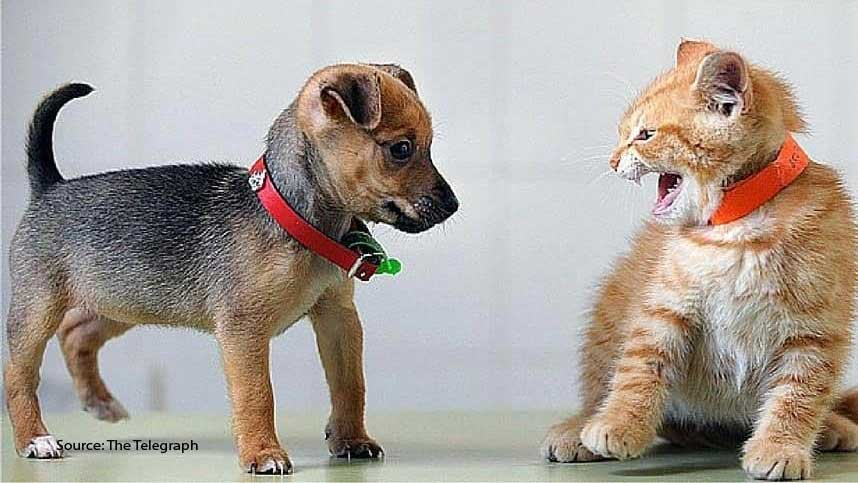

In [1]:
import cv2 # OpenCV

##### Link to kaggle: https://www.kaggle.com/c/dogs-vs-cats